# Trends in Delayed Flights Dataset
## by Edward Kyalo

## Investigation Overview

In exploring this dataset, I set out to find any observable trends in the arrival delay time and delay causes, in relation to the other variables in the dataset.

## Dataset Overview

The dataset contains information on the approximately 1,936,756 domestic flights within the United States during the year 2008. Additional datasets for interpreting carrier codes and iata codes were downloaded from The Bureau of Transportation Statistics website. 2 duplicate rows were removed. The dataset was otherwise left intact.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Import dataset csv file
df = pd.read_csv('DelayedFlights.csv', index_col=0)

# import additional files to assist in column formatting
df_carriers = pd.read_csv('carriers.csv')
df_airports = pd.read_csv('airports.csv')

In [3]:
# data wrangling, changing datatype, tidying date columns, et cetera
df['CRSDepTime'] = pd.to_datetime(df['CRSDepTime'].apply(int).apply(str).apply(lambda x: x.zfill(4)), format='%H%M').dt.time
df.rename(columns={'DayofMonth':'Day'}, inplace=True)
df['FlightDate'] = pd.to_datetime(df[['Year','Month','Day']])
df['FlightDate'] = pd.to_datetime(df.FlightDate.astype(str) + ' ' + df.CRSDepTime.astype(str))

df.loc[df['ArrDelay'] < 15.0, 'FlightStatus'] = 1
df.loc[df['ArrDelay'] >= 15.0, 'FlightStatus'] = 2
df.loc[df['Diverted'] == 1, 'FlightStatus'] = 3
df.loc[df['Cancelled'] == 1, 'FlightStatus'] = 4

df['FlightStatus'] = df['FlightStatus'].astype(int)
status_dict = {1:'On Time',2:'Late',3:'Diverted',4:'Cancelled'}

df[['FlightStatus','CancellationCode']] = df[['FlightStatus','CancellationCode']].astype('category')

In [4]:
# drop duplicated rows
df.drop_duplicates(inplace=True)

In [5]:
# drop unwanted columns
df = df.drop(columns=['Year','Month','Day','DayOfWeek','DepTime','ArrTime','CRSArrTime','FlightNum',
                      'TailNum','ActualElapsedTime','CRSElapsedTime','AirTime','DepDelay','Distance','TaxiIn',
                      'TaxiOut','Cancelled','Diverted'], axis=1)

In [6]:
# Setting base parameters for plots
plt.rcParams.update({'figure.figsize': (14, 7), 'figure.dpi': 150})
base_color = sb.color_palette()[0]
# calculate appropriate bin size for ArrDelay using Doane's formula and numpy
bins = len(np.histogram_bin_edges(df.loc[~df.ArrDelay.isna()].ArrDelay, bins='doane'))
#bins=int(np.around(np.sqrt(df.shape[0])))
# set whitegrid as default figure style
sb.set_style('whitegrid')

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of Arrival Delay

A histogram of arrival delay with extreme high outliers removed gives it a less skewed apearance. The highest (2461 minutes) and lowest (-109 minutes) values in the modified distribution are marked with the blue and red vertical lines. 


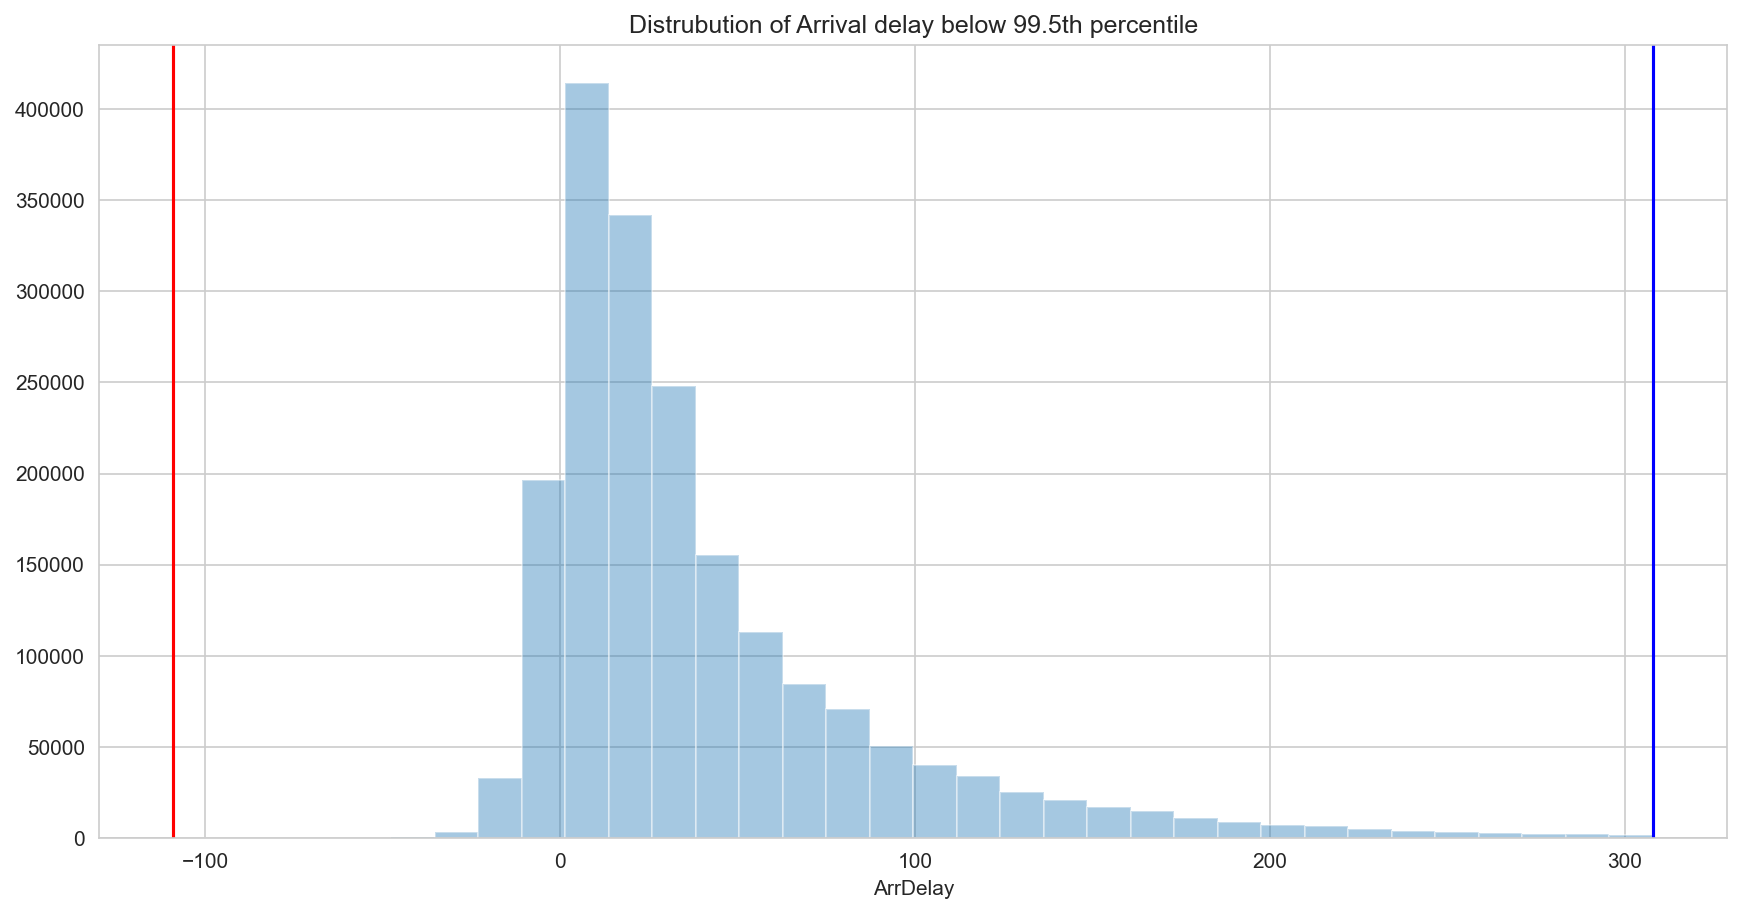

In [7]:
base_color = sb.color_palette()[0]
df_a = df.loc[df['ArrDelay'] < df.ArrDelay.quantile(0.995)]
bins_a = len(np.histogram_bin_edges(df_a.loc[~df_a.ArrDelay.isna()].ArrDelay, bins='doane'))

g = sb.distplot(df_a['ArrDelay'], bins=bins_a, kde=False, color=base_color);

g.axvline(x=df_a['ArrDelay'].max(), color='b', label='Max');
g.axvline(x=df_a['ArrDelay'].min(), color='r', label='Min');
plt.title('Distrubution of Arrival delay below 99.5th percentile');

## Mean Duration of each cause

Carrier, National Air System and Late Aircraft were the 3 delay caused with the highest mean delay. Weather and Security caused mean delays less than 5 minutes in 2008. 
  

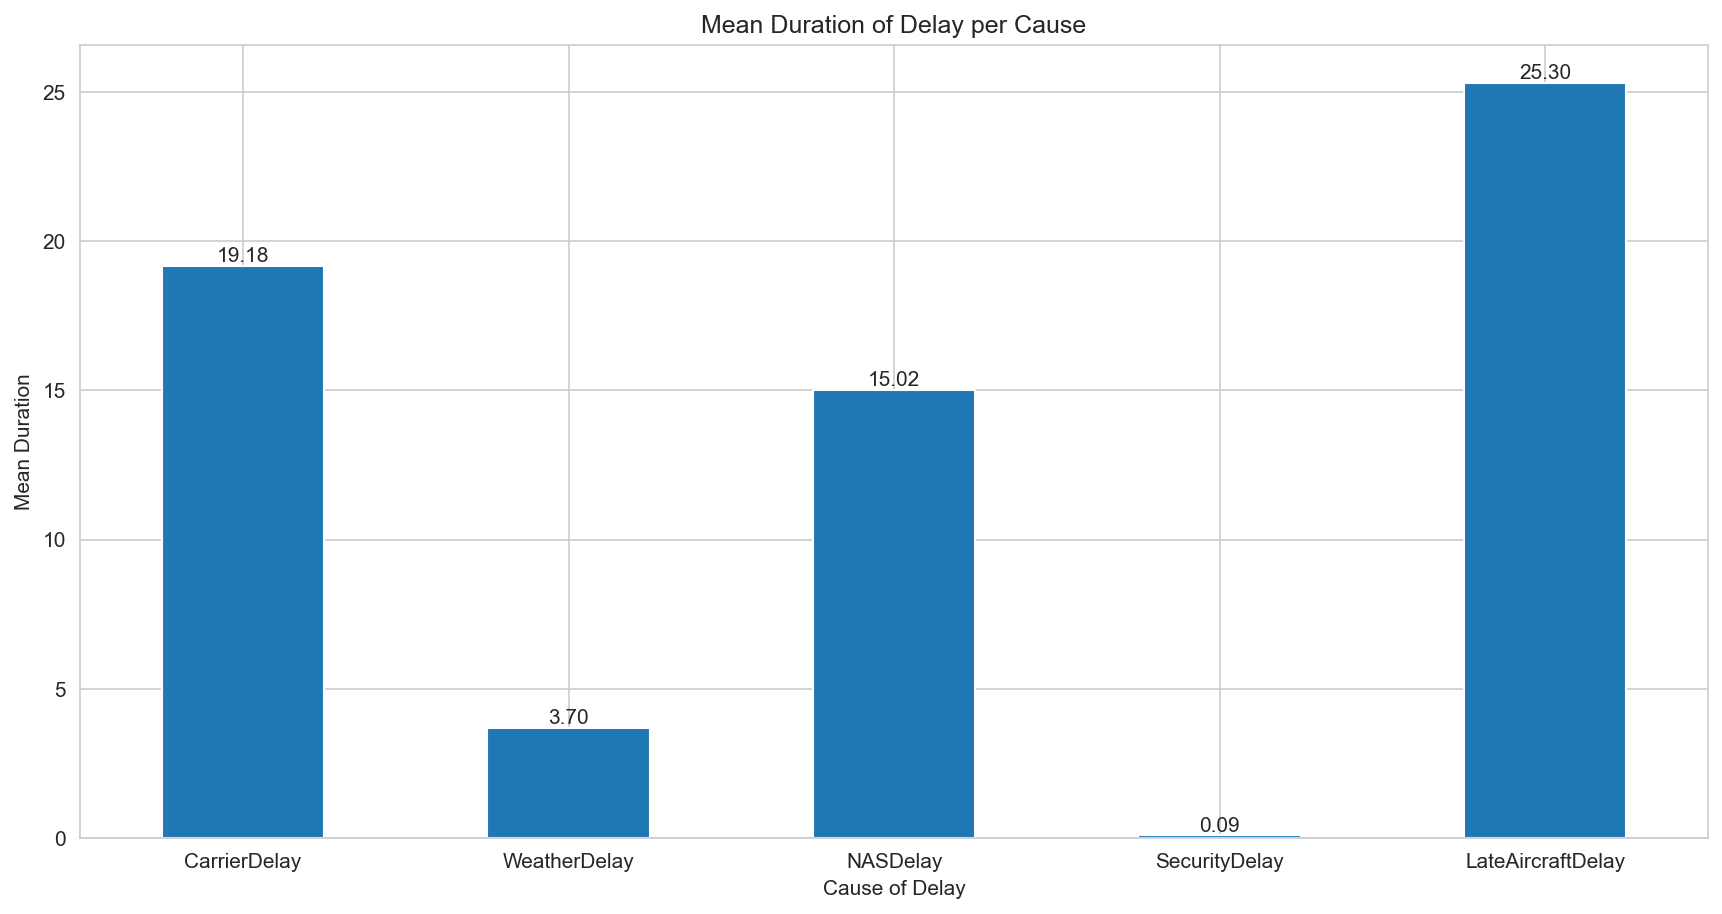

In [8]:
delay_list = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
g = df[delay_list].mean().plot(kind='bar')

for p in g.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    g.annotate('{:.2f}'.format(y), (x.mean(), y),
              ha='center', va='bottom')

plt.ylabel('Mean Duration')
plt.xticks(rotation=0)
plt.title('Mean Duration of Delay per Cause');
plt.xlabel('Cause of Delay');

## Mean Arrival Delay by Carrier

In this barchart, arranged in order of descending total flights operated, we see that carriers with fewer flights operated have a wider distribution of arrival delays. This is shown by the length of the vertical black lines above each bar. 
The 8 carriers with the lowest flights operated show a relationship with decreasing mean arrival delay.

The carrier codes and corresponding full carrier names are displayed above the chart

In [9]:
carrier_dict = dict(zip(df_carriers.Code, df_carriers.Description))

[('9E', 'Pinnacle Airlines Inc.'), ('AA', 'American Airlines Inc.'), ('AQ', 'Aloha Airlines Inc.'), ('AS', 'Alaska Airlines Inc.'), ('B6', 'JetBlue Airways'), ('CO', 'Continental Air Lines Inc.'), ('DL', 'Delta Air Lines Inc.'), ('EV', 'Atlantic Southeast Airlines'), ('F9', 'Frontier Airlines Inc.'), ('FL', 'AirTran Airways Corporation'), ('HA', 'Hawaiian Airlines Inc.'), ('MQ', 'American Eagle Airlines Inc.'), ('NW', 'Northwest Airlines Inc.'), ('OH', 'Comair Inc.'), ('OO', 'Skywest Airlines Inc.'), ('UA', 'United Air Lines Inc.'), ('US', 'US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)'), ('WN', 'Southwest Airlines Co.'), ('XE', 'Expressjet Airlines Inc.'), ('YV', 'Mesa Airlines Inc.')]


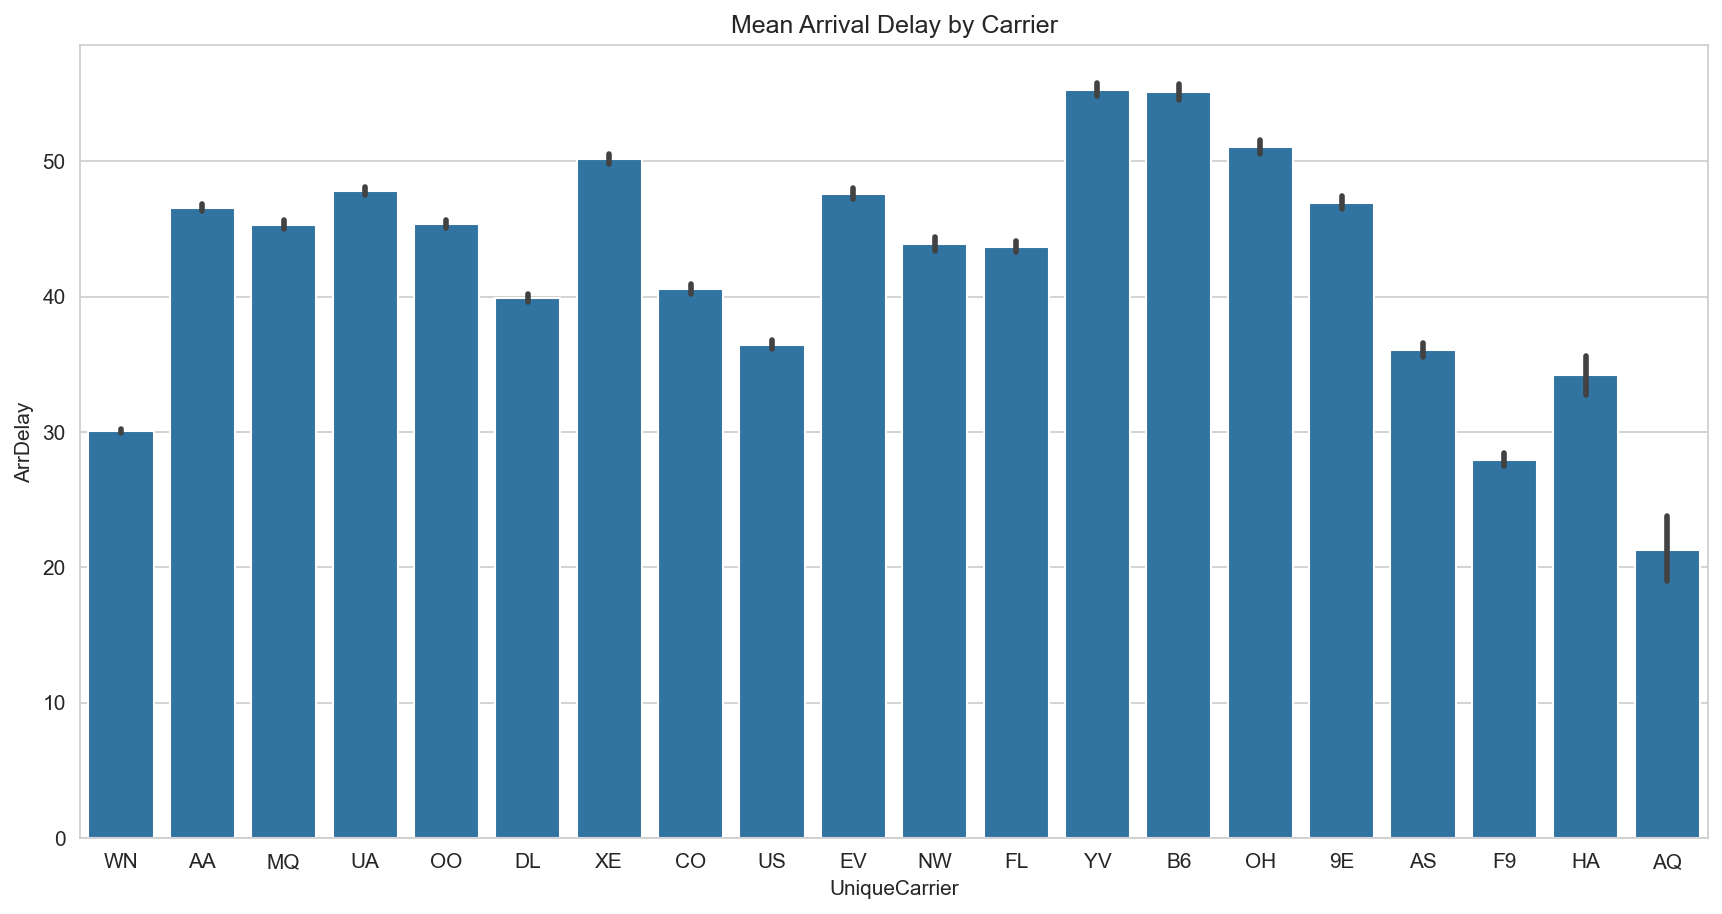

In [10]:
sb.barplot(data=df, x='UniqueCarrier', y='ArrDelay', order=df.UniqueCarrier.value_counts().index, color=sb.color_palette()[0]);
plt.title('Mean Arrival Delay by Carrier');
plt.xticks(rotation=0);

print([(i, carrier_dict[i]) for i in list(df.groupby('UniqueCarrier')['ArrDelay'].mean().index)])

## Total Delay by Cause per hour

This 15 minute rolling window linechart of total delay duration per hour for each delay cause shows that Carrier delays cause majority of the delays between the hours of 6am and 11am, while Late Aircraft cause majority of delays between 11am and 11pm. There are nearly zero flights between 11pm and 6am, hence the near zero total delay in that section of the chart.


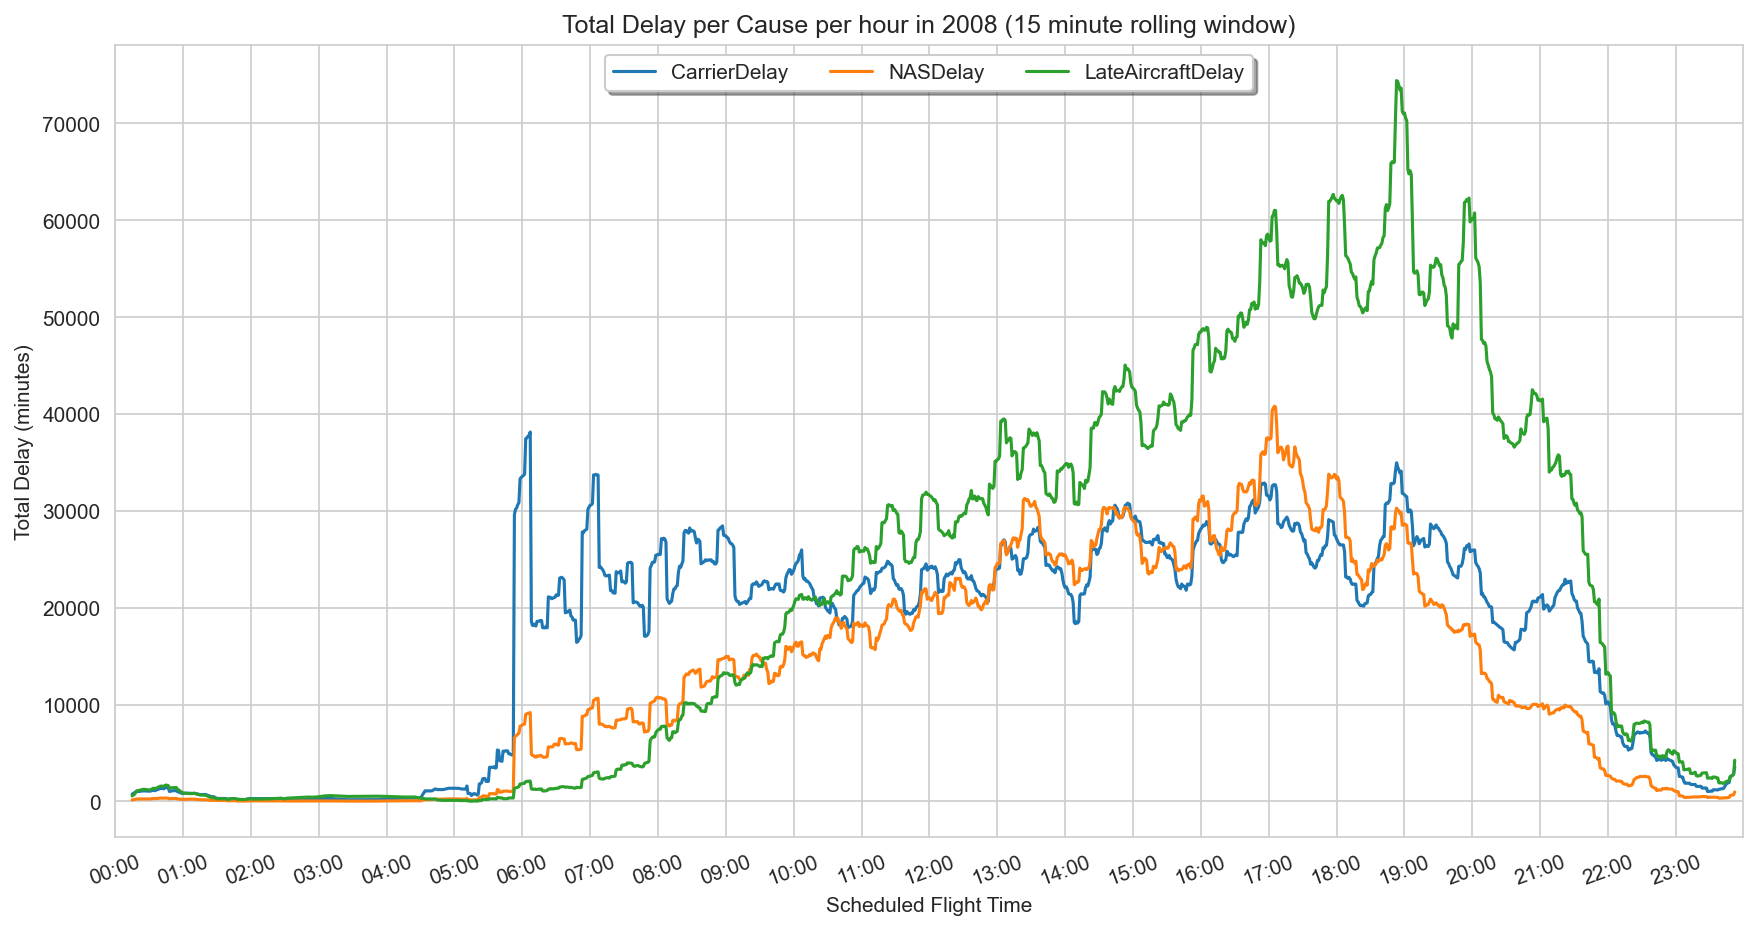

In [11]:
import datetime as dt
g = df.groupby(df.FlightDate.dt.time)['CarrierDelay','NASDelay','LateAircraftDelay'].sum().rolling(15).mean().shift(-7).plot()
g.legend(loc='upper center', ncol=3, fancybox=True, shadow=True)
hours = [dt.time(i).strftime('%H:%M') for i in range(24)]
plt.xticks(hours, hours, rotation=20);
plt.title('Total Delay per Cause per hour in 2008 (15 minute rolling window)');
plt.xlabel('Scheduled Flight Time');
plt.ylabel('Total Delay (minutes)');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!